> This notebook implements a LI-EKF and a RI-EKF for GNSS and Odometry integration

## Python Packages

In [19]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets

from collections import OrderedDict
from matplotlib import ticker
from matplotlib.patches import Rectangle
from navpy import lla2ned, ned2lla
from tqdm.autonotebook import tqdm
from scipy.spatial.transform import Rotation as Rot
from scipy.stats import norm
from scipy.linalg import inv, expm, logm
from scipy.stats import chi2

In [2]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif"
})
plt.rcParams['font.size'] = '18'

## Left-Invariant EKF Class for INS/GNSS Integration

In [3]:
class LIEKF:
    
    def __init__(self):
        """ Initialize the class by creating all the important variable """
        
        ''' Nominal State '''
        self.x  = []
        
        ''' Error State '''
        self.dx = []
        
        ''' Total number of steps processed '''
        self.steps = 0

        ''' Filter matrices '''
        self.P_dim = 15
        self.Q_dim = 15
        self.X_dim = 15
        self.IdP = np.eye(self.P_dim)
        self.IdQ = np.eye(self.Q_dim)
        self.Id3 = np.eye(3)
        self.Id6 = np.eye(6)
        self.P = np.eye(self.P_dim)
        self.N = np.eye(3)
        self.Q = np.eye(self.Q_dim)
        
        ''' Other '''
        self.g = np.array([0.,0.,-9.80665])
        
        
    def initialize(self, x):
        """ Initialize the filter with the nominal state vector """
        
        ''' Initial nominal state '''
        p_i_0 = np.array(x[0:3])
        v_i_0 = np.array(x[3:6])
        
        ''' Rotation sequence for Novatel '''
        p,r,a = np.array(x[6:9])
        R_i_0 = Rot.from_euler('xyz', [p, r, -a], degrees=True)
        b_w_0 = np.array(x[9:12])
        b_f_0 = np.array(x[12:15])
        self.x = [p_i_0, v_i_0, R_i_0, b_w_0, b_f_0]

        return None
        
    def current(self):
        """ Get the current nominal state vector """
        
        p_i, v_i, R_i, b_w, b_f = self.x
        
        pitch_i, roll_i, yaw_i = R_i.as_euler('xyz', degrees=True)
        
        # Normalize yaw
        factor = 180.    
        yaw_i = yaw_i % (2 * factor)    # force in range [0, 2 pi)
        if yaw_i > factor:          # move to [-pi, pi)
            yaw_i -= 2 * factor
        att_i = [pitch_i, roll_i, -yaw_i]
        
        return p_i, v_i, att_i, b_w, b_f
    
    
    def predict(self, u, dt):
        """ Predict the nominal states using the user inputs """
        
        self.steps += 1
        
        ''' Previous states '''
        p_i_prev, v_i_prev, R_i_prev, b_w_prev, b_f_prev = self.x
        
        ''' User inputs '''
        f_t = u[0:3]
        w_t = u[3:6]
        
        ''' Propagating nominal states '''    
        R = R_i_prev.as_matrix() @ expm(self._wedge((w_t-b_w_prev) * dt))
        R_i_updt = Rot.from_matrix(R)
        acc = R_i_prev.as_matrix().dot(f_t-b_f_prev) + self.g
        v_i_updt = v_i_prev + acc * dt
        p_i_updt = p_i_prev + v_i_prev * dt + acc * dt**2 * 0.5
        b_w_updt = b_w_prev
        b_f_updt = b_f_prev
        self.x = [p_i_updt, v_i_updt, R_i_updt, b_w_updt, b_f_updt]
        
        ''' Propagating the covariance '''
        A = np.zeros((self.P_dim,self.P_dim))
        A[0:3,0:3] = -self._wedge(w_t-b_w_prev)
        A[0:3,9:12] = -self.Id3
        A[3:6,0:3] = -self._wedge(f_t-b_f_prev)
        A[3:6,3:6] = -self._wedge(w_t-b_w_prev)
        A[3:6,12:15] = -self.Id3
        A[6:9,3:6] = self.Id3
        A[6:9,6:9] = -self._wedge(w_t-b_w_prev)
        
        F = self.IdP + A * dt
        G = self.IdQ * dt
        self.P = F @ self.P @ F.T + G @ self.Q @ G.T
        self.P = 0.5 * np.add(self.P, self.P.T)
        
        return None
    
    
    def correct(self, y):
        """ Correct the nominal states using the measurements """
        
        ''' Current states '''
        p_i_curr, v_i_curr, R_i_curr, b_w_curr, b_f_curr = self.x
                
        X = self._pack(R_i_curr.as_matrix(), v_i_curr, p_i_curr)
        inv_X = inv(X)
        N = self.N
        
        ''' Kalman Gain '''
        H = np.zeros((6, self.X_dim))
        H[0:6, 3:9] = self.Id6
        S = H @ self.P @ H.T + N
        K = self.P @ H.T @ inv(S)
        
        ''' Error state '''
        Y = np.array([*y[0:3], 1, 0])
        b = np.zeros(5)
        b[3] = 1
        z_vel = inv_X.dot(Y) - b
        
        Y = np.array([*y[3:6], 0, 1])
        b = np.zeros(5)
        b[4] = 1
        z_pos = inv_X.dot(Y) - b
        
        z = np.concatenate((z_vel[0:3],z_pos[0:3]))
        e = K.dot(z)
        self.dx = e
        
        ''' Mapping the error '''
        Lg = np.zeros((5, 5))
        Lg[0:3, 0:3] = self._wedge(e[:3])
        Lg[0:3, 3] = e[3:6]
        Lg[0:3, 4] = e[6:9]
        delta = expm(Lg)
        
        ''' Correcting states '''
        X_updt = X @ delta
        R_i_curr = Rot.from_matrix(X_updt[:3,:3])
        v_i_curr = np.squeeze(X_updt[:3,3])
        p_i_curr = np.squeeze(X_updt[:3,4])
        # b_w_curr += e[9:12]
        # b_f_curr += e[12:15]
        self.x = [p_i_curr, v_i_curr, R_i_curr, b_w_curr, b_f_curr]
        
        ''' Covariance '''
        self.P = (self.IdP - K @ H) @ self.P @ np.transpose(self.IdP - K @ H) + K @ self.N @ K.T
        self.P = 0.5 * np.add(self.P, self.P.T)

        return None 
    

    def _Adx(self):
        p_i_curr, v_i_curr, R_i_curr, b_w_curr, b_f_curr = self.x
        Adx = np.zeros((9, 9))
        Adx[0:3,0:3] = R_i_curr.as_matrix()
        Adx[3:6,0:3] = self._wedge(v_i_curr) @ R_i_curr.as_matrix()
        Adx[3:6,3:6] = R_i_curr.as_matrix()
        Adx[6:9,0:3] = self._wedge(p_i_curr) @ R_i_curr.as_matrix()
        Adx[6:9,6:9] = R_i_curr.as_matrix()
        return Adx
    
    def _Adx_inv(self):
        p_i_curr, v_i_curr, R_i_curr, b_w_curr, b_f_curr = self.x
        Adx = np.zeros((9, 9))
        Adx[0:3,0:3] = R_i_curr.as_matrix().T
        Adx[3:6,0:3] = -R_i_curr.as_matrix().T @ self._wedge(v_i_curr)
        Adx[3:6,3:6] = R_i_curr.as_matrix().T
        Adx[6:9,0:3] = -R_i_curr.as_matrix().T @ self._wedge(p_i_curr)
        Adx[6:9,6:9] = R_i_curr.as_matrix().T
        return Adx
    
    
    def Pl_to_Pr(self):
        Adx = self._Adx()
        Σ = np.zeros((self.X_dim,self.X_dim))
        Σ[0:9,0:9] = Adx
        Σ[9:15,9:15] = self.Id6
        return Σ @ self.P @ Σ.T
    
    
    @staticmethod
    def _wedge(v):
        v0, v1, v2 = v
        M = np.array([[0., -v2, v1],
                      [v2, 0., -v0],
                      [-v1, v0, 0.]])
        return M
    
    @staticmethod
    def _vee(M):
        v0 = M[2,1]
        v1 = M[0,2]
        v2 = M[1,0]
        return np.array([v0,v1,v2])
    
    @staticmethod
    def _pack(R, v, p):
        X = np.eye(5)
        X[0:3, 0:3] = R
        X[0:3, 3] = v
        X[0:3, 4] = p
        return X
    
    @staticmethod
    def _unpack(X):
        R = X[0:3, 0:3]
        p = X[0:3, 3]
        v = X[0:3, 4]
        return R, v, p

## Right-Invariant EKF Class for INS/Odometry Integration

In [4]:
class RIEKF:
    
    def __init__(self):
        """ Initialize the class by creating all the important variable """
        
        ''' Nominal State '''
        self.x  = []
        
        ''' Error State '''
        self.dx = []
        
        ''' Total number of steps processed '''
        self.steps = 0

        ''' Filter matrices '''
        self.P_dim = 15
        self.Q_dim = 15
        self.X_dim = 15
        self.IdP = np.eye(self.P_dim)
        self.IdQ = np.eye(self.Q_dim)
        self.Id3 = np.eye(3)
        self.Id6 = np.eye(6)
        self.P = np.eye(self.P_dim)
        self.N = np.eye(3)
        self.Q = np.eye(self.Q_dim)
        
        ''' Other '''
        self.g = np.array([0.,0.,-9.80665])
        
        
    def initialize(self, x):
        """ Initialize the filter with the nominal state vector """
        
        ''' Initial nominal state '''
        p_i_0 = np.array(x[0:3])
        v_i_0 = np.array(x[3:6])
        
        ''' Rotation sequence for Novatel '''
        p,r,a = np.array(x[6:9])
        R_i_0 = Rot.from_euler('xyz', [p, r, -a], degrees=True)
        b_w_0 = np.array(x[9:12])
        b_f_0 = np.array(x[12:15])
        self.x = [p_i_0, v_i_0, R_i_0, b_w_0, b_f_0]

        return None
        
    def current(self):
        """ Get the current nominal state vector """
        
        p_i, v_i, R_i, b_w, b_f = self.x
        
        pitch_i, roll_i, yaw_i = R_i.as_euler('xyz', degrees=True)
        
        # Normalize yaw
        factor = 180.    
        yaw_i = yaw_i % (2 * factor)    # force in range [0, 2 pi)
        if yaw_i > factor:          # move to [-pi, pi)
            yaw_i -= 2 * factor
        att_i = [pitch_i, roll_i, -yaw_i]
        
        return p_i, v_i, att_i, b_w, b_f
    
    
    def predict(self, u, dt):
        """ Predict the nominal states using the user inputs """
        
        self.steps += 1
        
        ''' Previous states '''
        p_i_prev, v_i_prev, R_i_prev, b_w_prev, b_f_prev = self.x
        
        ''' User inputs '''
        f_t = u[0:3]
        w_t = u[3:6]
        
        ''' Propagating nominal states '''    
        R = R_i_prev.as_matrix() @ expm(self._wedge((w_t-b_w_prev) * dt))
        R_i_updt = Rot.from_matrix(R)
        acc = R_i_prev.as_matrix().dot(f_t-b_f_prev) + self.g
        v_i_updt = v_i_prev + acc * dt
        p_i_updt = p_i_prev + v_i_prev * dt + acc * dt**2 * 0.5
        b_w_updt = b_w_prev
        b_f_updt = b_f_prev
        self.x = [p_i_updt, v_i_updt, R_i_updt, b_w_updt, b_f_updt]
        
        ''' Propagating the covariance '''
        A = np.zeros((self.P_dim,self.P_dim))
        A[0:3,9:12] = -R_i_prev.as_matrix()
        A[3:6,0:3] = self._wedge(self.g)
        A[3:6,9:12] = -self._wedge(v_i_prev) @ R_i_prev.as_matrix()
        A[3:6,12:15] = -R_i_prev.as_matrix()
        A[6:9,3:6] = self.Id3
        A[6:9,9:12] = -self._wedge(p_i_prev) @ R_i_prev.as_matrix()
                
        B = np.zeros((self.P_dim,self.P_dim))
        B[0:3,0:3] = R_i_prev.as_matrix()
        B[3:6,0:3] = self._wedge(v_i_prev) @ R_i_prev.as_matrix()
        B[3:6,3:6] = R_i_prev.as_matrix()
        B[6:9,0:3] = self._wedge(p_i_prev) @ R_i_prev.as_matrix()
        B[6:9,6:9] = R_i_prev.as_matrix()
        B[9:15,9:15] = self.Id6
        
        F = self.IdP + A * dt
        G = B * dt
        self.P = F @ self.P @ F.T + G @ self.Q @ G.T
        self.P = 0.5 * np.add(self.P, self.P.T)
        
        return None
    
    
    def correct(self, y):
        """ Correct the nominal states using the measurements """
        
        ''' Current states '''
        p_i_curr, v_i_curr, R_i_curr, b_w_curr, b_f_curr = self.x
                
        X = self._pack(R_i_curr.as_matrix(), v_i_curr, p_i_curr)
        inv_X = inv(X)
        N = self.N
        
        ''' Kalman Gain '''
        H = np.zeros((3, self.X_dim))
        H[0:3, 3:6] = self.Id3
        S = H @ self.P @ H.T + N
        K = self.P @ H.T @ inv(S)
        
        ''' Error state '''
        Y = np.array([*y[0:3], -1, 0])
        b = np.zeros(5)
        b[3] = -1
        z = X.dot(Y) - b
        e = K.dot(z[0:3])
        self.dx = e
        
        ''' Mapping the error '''
        Lg = np.zeros((5, 5))
        Lg[0:3, 0:3] = self._wedge(e[:3])
        Lg[0:3, 3] = e[3:6]
        Lg[0:3, 4] = e[6:9]
        delta = expm(Lg)
        
        ''' Correcting states '''
        X_updt = delta @ X
        R_i_curr = Rot.from_matrix(X_updt[:3,:3])
        v_i_curr = np.squeeze(X_updt[:3,3])
        p_i_curr = np.squeeze(X_updt[:3,4])
        # b_w_curr += e[9:12]
        # b_f_curr += e[12:15]
        self.x = [p_i_curr, v_i_curr, R_i_curr, b_w_curr, b_f_curr]
        
        ''' Covariance '''
        self.P = (self.IdP - K @ H) @ self.P @ np.transpose(self.IdP - K @ H) + K @ self.N @ K.T
        self.P = 0.5 * np.add(self.P, self.P.T)

        return None 
    
    
    def _Adx(self):
        p_i_curr, v_i_curr, R_i_curr, b_w_curr, b_f_curr = self.x
        Adx = np.zeros((9, 9))
        Adx[0:3,0:3] = R_i_curr.as_matrix()
        Adx[3:6,0:3] = self._wedge(v_i_curr) @ R_i_curr.as_matrix()
        Adx[3:6,3:6] = R_i_curr.as_matrix()
        Adx[6:9,0:3] = self._wedge(p_i_curr) @ R_i_curr.as_matrix()
        Adx[6:9,6:9] = R_i_curr.as_matrix()
        return Adx
    

    def _Adx_inv(self):
        p_i_curr, v_i_curr, R_i_curr, b_w_curr, b_f_curr = self.x
        Adx = np.zeros((9, 9))
        Adx[0:3,0:3] = R_i_curr.as_matrix().T
        Adx[3:6,0:3] = -R_i_curr.as_matrix().T @ self._wedge(v_i_curr)
        Adx[3:6,3:6] = R_i_curr.as_matrix().T
        Adx[6:9,0:3] = -R_i_curr.as_matrix().T @ self._wedge(p_i_curr)
        Adx[6:9,6:9] = R_i_curr.as_matrix().T
        return Adx
    
    
    def Pr_to_Pl(self):
        Adx = self._Adx_inv()
        Ω = np.zeros((self.X_dim,self.X_dim))
        Ω[0:9,0:9] = Adx
        Ω[9:15,9:15] = self.Id6
        return Ω @ self.P @ Ω.T
    
    
    @staticmethod
    def _wedge(v):
        v0, v1, v2 = v
        M = np.array([[0., -v2, v1],
                      [v2, 0., -v0],
                      [-v1, v0, 0.]])
        return M
    
    @staticmethod
    def _vee(M):
        v0 = M[2,1]
        v1 = M[0,2]
        v2 = M[1,0]
        return np.array([v0,v1,v2])
    
    @staticmethod
    def _pack(R, v, p):
        X = np.eye(5)
        X[0:3, 0:3] = R
        X[0:3, 3] = v
        X[0:3, 4] = p
        return X
    
    @staticmethod
    def _unpack(X):
        R = X[0:3, 0:3]
        p = X[0:3, 3]
        v = X[0:3, 4]
        return R, v, p

## Analysis Class

In [60]:
class Analysis:
    
    def __init__(self, container):
        # Reserved colors
        # self.colors = ['magenta','turquoise','k','gold','b']
        self.colors = ['magenta','k','turquoise','gold','b']
        # self.colors = ['#DB162F','#080708','#2D4B73','#D9B70D','#99B4BF','#BF8D30']
        
        self.methods = [method for method in container.keys() if method not in ['Time','gnss']]
        temp = np.array(container['Time']).reshape((-1,1))
        columns = ['Time']
        for method in self.methods:
            temp = np.concatenate([temp,np.array(container[method])], axis=1)
            columns += [method+'.east',method+'.north',method+'.up',
                        method+'.ve',method+'.vn',method+'.vu',
                        method+'.pitch',method+'.roll',method+'.azi']
        self.df = pd.DataFrame(temp, columns=columns)
        self.init_t = self.df.Time.iat[0]
        self.df.loc[:,'Time'] -= self.init_t
        self.df.loc[:,'Time'] /= 60.
        
        if len(container['gnss']) > 0:
            self.gnss = pd.DataFrame(np.array(container['gnss']), columns=['gnss.east','gnss.north','gnss.up'])
        else:
            self.gnss = None

        return None
    
    def meta(self):
        dist = np.sum(np.sqrt(np.sum(np.square(self.df.loc[:,['ref.east','ref.north','ref.up']].to_numpy()[1:,:] - self.df.loc[:,['ref.east','ref.north','ref.up']].to_numpy()[:-1,:]), axis=1)))
        print(f'Travelled distance: {dist} m')
        print(f'Travelled time: {self.df.Time.iat[-1]} min')
        return None
    
    def export(self, path):
        # Exporting poses
        for method in self.methods:
            all_data = []
            p = self.df.loc[:,method+'.pitch'].tolist()
            r = self.df.loc[:,method+'.roll'].tolist()
            a = self.df.loc[:,method+'.azi'].tolist()
            e = self.df.loc[:,method+'.east'].tolist()
            n = self.df.loc[:,method+'.north'].tolist()
            u = self.df.loc[:,method+'.east'].tolist()
            N = len(p)
            for i in range(N):
                R = Rot.from_euler('xyz', [p[i], r[i], -a[i]], degrees=True)
                t = [-e[i], u[i], n[i]]
                T = np.eye(4)
                T[0:3,0:3] = R.as_matrix()
                T[0:3,3] = t
                all_data.append(np.ravel(T)[:12])
            all_data = np.array(all_data)
            np.savetxt(os.path.join(path, method+'.txt'), all_data, fmt='%1.6e')
        return None
            
    
    def cdf(self):
        filtered_methods = [method for method in self.methods if method != 'ref']
        
        fig, (ax1,ax2) = plt.subplots(1,2, figsize=[12.8, 4.8])
        # fig.suptitle('Cumulative Distribution Function')
        ax1.set_prop_cycle('color', self.colors[2:])
        ax2.set_prop_cycle('color', self.colors[2:])
        # ax1.set_title('Horizontal Error')
        # ax2.set_title('Vertical Error')
        ax1.set_xlabel('Error [m]')
        ax2.set_xlabel('Error [m]')
        ax1.set_ylim([0.,1.01])
        ax2.set_ylim([0.,1.01])
        ax1.grid(linestyle=':')
        ax2.grid(linestyle=':')
        ax1.set_xlim(left=0, right=0.01)
        ax2.set_xlim(left=0, right=0.01)
        max_herr = []
        max_verr = []
        # lines = ['-','-','-','-']
        lines = [':','-','-']

        # Calculating errors
        for filtered_method in filtered_methods:
            # Position errors
            herr = np.sqrt(np.square(self.df.loc[:,'ref.east'].to_numpy() - self.df.loc[:,filtered_method +'.east'].to_numpy()) + 
                           np.square(self.df.loc[:,'ref.north'].to_numpy() - self.df.loc[:,filtered_method +'.north'].to_numpy()))
            verr = np.abs(self.df.loc[:,'ref.up'].to_numpy() - self.df.loc[:,filtered_method +'.up'].to_numpy())
            herr = np.sort(herr)
            verr = np.sort(verr)
            herr_cdf = np.arange(herr.shape[0]) / float(herr.shape[0])
            verr_cdf = np.arange(verr.shape[0]) / float(verr.shape[0])
            s = lines.pop(0)
            ax1.plot(herr, herr_cdf, s, label=filtered_method)
            ax2.plot(verr, verr_cdf, s, label=filtered_method)
            max_herr.append(herr[-1])
            max_verr.append(verr[-1])
                    
        # Finishing plots
        ax1.yaxis.set_major_formatter(ticker.PercentFormatter(1.0))
        ax2.yaxis.set_major_formatter(ticker.PercentFormatter(1.0))
        ax1.set_xlim(left=0,right=min(max_herr))
        ax1.set_ylim(bottom=0,top=1.01)
        ax2.set_xlim(left=0,right=min(max_verr))
        ax2.set_ylim(bottom=0,top=1.01)
        ax1.legend(fancybox=False)
        ax2.legend(fancybox=False)
        plt.show()
        # plt.close(fig)
        return None
    
        
    def states(self, path=''):
        t = self.df.loc[:,'Time'].to_numpy()
        
        # 2D trajectory
        # lines = ['-','-','-','-']
        lines = ['-','-','-']
        fig, (ax1,ax2) = plt.subplots(1, 2 , figsize=[13.4, 6.8])
        
        ax1.plot(self.df.loc[:,'ref.east'].to_numpy(), self.df.loc[:,'ref.north'].to_numpy(), '--', color=self.colors[1], label='ref')
        ax2.plot(self.df.loc[:,'ref.east'].to_numpy(), self.df.loc[:,'ref.north'].to_numpy(), '--', color=self.colors[1], label='ref')
        
        if not self.gnss is None:
            ax1.plot(self.gnss.loc[:,'gnss.east'].values, self.gnss.loc[:,'gnss.north'].values, 'o', markersize=5, color=self.colors[0], label='gnss')
            ax2.plot(self.gnss.loc[:,'gnss.east'].values, self.gnss.loc[:,'gnss.north'].values, 'o', markersize=5, color=self.colors[0], label='gnss')
        
        ax1.set_prop_cycle('color', self.colors[2:])
        ax2.set_prop_cycle('color', self.colors[2:])
        filtered_methods = [method for method in self.methods if method != 'ref']
        
        for method in filtered_methods:
            s = lines.pop(0)
            ax1.plot(self.df.loc[:,method +'.east'].to_numpy(), self.df.loc[:,method +'.north'].to_numpy(), s, label=method)
            ax2.plot(self.df.loc[:,method +'.east'].to_numpy(), self.df.loc[:,method +'.north'].to_numpy(), s, label=method)
            
        ax1.set_xlim(left=self.df.loc[:,'ref.east'].to_numpy().min()-400,right=self.df.loc[:,'ref.east'].to_numpy().max()+400)
        ax1.set_ylim(bottom=self.df.loc[:,'ref.north'].to_numpy().min()-400,top=self.df.loc[:,'ref.north'].to_numpy().max()+400)
        ax2.set_xlim([100,500])
        ax2.set_ylim([-1400,-1000])
        # ax1.set_aspect('equal','box')
        # ax2.set_aspect('equal','box')
        # ax.set_title('2D Trajectory')
        ax1.set_xlabel('East [m]')
        ax1.set_ylabel('North [m]')
        # ax2.set_xlabel('East [m]')
        # ax2.set_ylabel('North [m]')
        ax1.annotate('start', xy=(self.df.loc[:,'ref.east'].iat[0], self.df.loc[:,'ref.north'].iat[0]), xytext=(self.df.loc[:,'ref.east'].iat[0]+50, self.df.loc[:,'ref.north'].iat[0]+50), xycoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="angle3"))
        ax1.annotate('end', xy=(self.df.loc[:,'ref.east'].iat[-1], self.df.loc[:,'ref.north'].iat[-1]), xytext=(self.df.loc[:,'ref.east'].iat[-1]+50, self.df.loc[:,'ref.north'].iat[-1]+50), xycoords='data',
            arrowprops=dict(arrowstyle="->", connectionstyle="angle3"))  
        ax1.legend(loc='upper right', fancybox=False)
        # ax2.legend(fancybox=False)
        ax1.grid(linestyle=':')
        ax2.grid(linestyle=':')
        
        ax1.add_patch(Rectangle((500, -1000), -400, -300,
             edgecolor = 'grey',
             # facecolor = 'blue',
             fill=False,
             lw=2,
             linestyle='--'))
        
        ax2.spines["top"].set_color("grey")
        ax2.spines["bottom"].set_color("grey")
        ax2.spines["left"].set_color("grey")
        ax2.spines["right"].set_color("grey")
        ax2.spines["top"].set_linestyle("--")
        ax2.spines["bottom"].set_linestyle("--")
        ax2.spines["left"].set_linestyle("--")
        ax2.spines["right"].set_linestyle("--")
        ax2.spines["top"].set_linewidth(2)
        ax2.spines["bottom"].set_linewidth(2)
        ax2.spines["left"].set_linewidth(2)
        ax2.spines["right"].set_linewidth(2)
        
        ax2.set_yticks([])
        ax2.set_xticks([])
        plt.tight_layout()
        plt.show()
        
        # Figure for attitude angles
        fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=[10.4, 6.8], sharex=True)

        ax1.set_prop_cycle('color', self.colors[1:])
        ax2.set_prop_cycle('color', self.colors[1:])
        ax3.set_prop_cycle('color', self.colors[1:])

        ax1.set_title('pitch')
        ax2.set_title('roll')
        ax3.set_title('azimuth')

        ax1.set_ylabel('[deg]')
        ax2.set_ylabel('[deg]')
        ax3.set_ylabel('[deg]')

        ax1.grid(linestyle=':')
        ax2.grid(linestyle=':')
        ax3.grid(linestyle=':')

        ax1.set_facecolor('white')
        ax2.set_facecolor('white')
        ax3.set_facecolor('white')

        ax3.set_xlabel('Time [min]')

        for method in self.methods:
            if method == 'ref':
                s = '--'
            else:
                s = '-'
            ax1.plot(t, self.df.loc[:,method+'.pitch'].to_numpy(), s)
            ax2.plot(t, self.df.loc[:,method+'.roll'].to_numpy(), s)
            ax3.plot(t, self.df.loc[:,method+'.azi'].to_numpy(), s)

        ax1.legend(self.methods, fancybox=False)
        ax2.legend(self.methods, fancybox=False)
        ax3.legend(self.methods, fancybox=False)
        
        ax1.set_xlim([0, np.max(t)])
        ax2.set_xlim([0, np.max(t)])
        ax3.set_xlim([0, np.max(t)])
        plt.show()

        # Figure for velocities
        fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=[10.4, 6.8], sharex=True)

        ax1.set_prop_cycle('color', self.colors[1:])
        ax2.set_prop_cycle('color', self.colors[1:])
        ax3.set_prop_cycle('color', self.colors[1:])

        ax1.set_title('ve')
        ax2.set_title('vn')
        ax3.set_title('vu')

        ax1.set_ylabel('[m/s]')
        ax2.set_ylabel('[m/s]')
        ax3.set_ylabel('[m/s]')

        ax1.grid(linestyle=':')
        ax2.grid(linestyle=':')
        ax3.grid(linestyle=':')

        ax1.set_facecolor('white')
        ax2.set_facecolor('white')
        ax3.set_facecolor('white')
        
        ax3.set_xlabel('Time [min]')

        for method in self.methods:
            if method == 'ref':
                s = '--'
            else:
                s = '-'
            ax1.plot(t, self.df.loc[:,method+'.ve'].to_numpy(), s)
            ax2.plot(t, self.df.loc[:,method+'.vn'].to_numpy(), s)
            ax3.plot(t, self.df.loc[:,method+'.vu'].to_numpy(), s)

        ax1.set_xlim([0, np.max(t)])
        ax2.set_xlim([0, np.max(t)])
        ax3.set_xlim([0, np.max(t)])    
        
        ax1.legend(self.methods, fancybox=False)
        ax2.legend(self.methods, fancybox=False)
        ax3.legend(self.methods, fancybox=False)
        plt.show()
        
        # plt.close(fig)
        
        return None
    
    def boundaries(self, boundaries):
        print('\n*** BOUNDARIES ***\n')
        
        # Horizontal error
        herr_list = []
        verr_list = []
        herr_list.append(boundaries)
        verr_list.append(boundaries)
        herr_columns = ['HERR']
        verr_columns = ['VERR']
        filtered_methods = [method for method in self.methods if method != 'ref']

        for filtered_method in filtered_methods:
            herr_columns.append(filtered_method)
            verr_columns.append(filtered_method)
            # Position errors
            herr = np.sqrt(np.square(self.df.loc[:,'ref.east'].to_numpy() - self.df.loc[:,filtered_method +'.east'].to_numpy()) + 
                           np.square(self.df.loc[:,'ref.north'].to_numpy() - self.df.loc[:,filtered_method +'.north'].to_numpy()))
            verr = np.abs(self.df.loc[:,'ref.up'].to_numpy() - self.df.loc[:,filtered_method +'.up'].to_numpy())

            local_herr_list = []
            local_verr_list = []
            for b in boundaries:
                b_herr = (np.sum(herr <= b)/len(herr)) * 100
                b_verr = (np.sum(verr <= b) / len(verr)) * 100
                local_herr_list.append(b_herr)
                local_verr_list.append(b_verr)

            herr_list.append(local_herr_list)
            verr_list.append(local_verr_list)

        herr_df = pd.DataFrame(list(zip(*herr_list)), columns=herr_columns)
        verr_df = pd.DataFrame(list(zip(*verr_list)), columns=verr_columns)

        print(herr_df)
        print()
        print(verr_df)
        return None
    
    
    def outages(self, outages):
        print('\n*** OUTAGES ***\n')
        filtered_methods = [method for method in self.methods if method != 'ref']
        # Detecting gaps assuming GNSS reading every second
        for n, (i, e) in enumerate(outages):
            i = (i - self.init_t) / 60
            e = (e - self.init_t) / 60
            # Indexes to compute absolute errors
            idx_abs = self.df.loc[:,'Time'] <= i
            # Indexes to compute relative errors
            idx_rel = np.bitwise_and(self.df.loc[:,'Time'] > i, self.df.loc[:,'Time'] < e)
            # print(np.argwhere(self.df.Time.values > i).tolist(),np.argwhere(self.df.Time.values < e).tolist())
            # Distance traveled
            gap = self.df.loc[idx_rel,['ref.east','ref.north','ref.up']].to_numpy()
            dist = np.sum(np.sqrt(np.sum(np.square(gap[1:,:] - gap[:-1,:]), axis=1)))
            # Computing errors for each method
            print(f'OUTAGE {n+1} (Init: {i} | End: {e} | Interval: {round((e-i)*60,3)}s | Distance: {round(dist,3)}m)')     
            for filtered_method in filtered_methods:
                # Absolute position errors
                rmse_herr_abs = np.mean(np.sqrt(np.square(self.df.loc[idx_abs,'ref.east'].to_numpy() - self.df.loc[idx_abs,filtered_method +'.east'].to_numpy()) + 
                               np.square(self.df.loc[idx_abs,'ref.north'].to_numpy() - self.df.loc[idx_abs,filtered_method +'.north'].to_numpy())))
                rmse_verr_abs = np.mean(np.abs(self.df.loc[idx_abs,'ref.up'].to_numpy() - self.df.loc[idx_abs,filtered_method +'.up'].to_numpy()))
                # Relative position errors
                rmse_herr_rel = np.mean(np.sqrt(np.square(self.df.loc[idx_rel,'ref.east'].to_numpy() - self.df.loc[idx_rel,filtered_method +'.east'].to_numpy()) + 
                               np.square(self.df.loc[idx_rel,'ref.north'].to_numpy() - self.df.loc[idx_rel,filtered_method +'.north'].to_numpy())))
                rmse_verr_rel = np.mean(np.abs(self.df.loc[idx_rel,'ref.up'].to_numpy() - self.df.loc[idx_rel,filtered_method +'.up'].to_numpy()))
                print(f'{filtered_method}\n\t HERR RMSE (abs): {round(rmse_herr_abs,3)}m | VERR RMSE (abs): {round(rmse_verr_abs,3)}m'
                                       f'\n\t HERR RMSE (rel): {round(abs(rmse_herr_rel-rmse_herr_abs),3)}m | % of Distance: {round(abs(rmse_herr_rel-rmse_herr_abs)/dist*100,3)}'
                                       f'\n\t VERR RMSE (rel): {round(abs(rmse_verr_rel-rmse_verr_abs),3)}m | % of Distance: {round(abs(rmse_verr_rel-rmse_verr_abs)/dist*100,3)}\n')
        return None

## User Parameters

In [6]:
search_path = '../data/'
_, dirs, _ = next(os.walk(search_path), ([],[],[]))
trajmulti=widgets.SelectMultiple(
    options=sorted(dirs),
    description='Trajectories:',
    disabled=False
)

In [7]:
trajmulti

SelectMultiple(description='Trajectories:', options=('2022-05-16-10-31-07', '2022-05-16-11-02-59', '2022-09-05…

## Evaluating the trajectories

Seq. 01: 9.75 * 60 | front-right
Seq. 02: 18 * 60 | front-left

In [46]:
stop_early = True
total_time = 18 * 60  # 10.2

===== TRAJECTORY: 2022-09-06-12-55-08 =====


  0%|          | 0/377916 [00:00<?, ?it/s]

Travelled distance: 5411.146238775906 m
Travelled time: 17.999751035372416 min


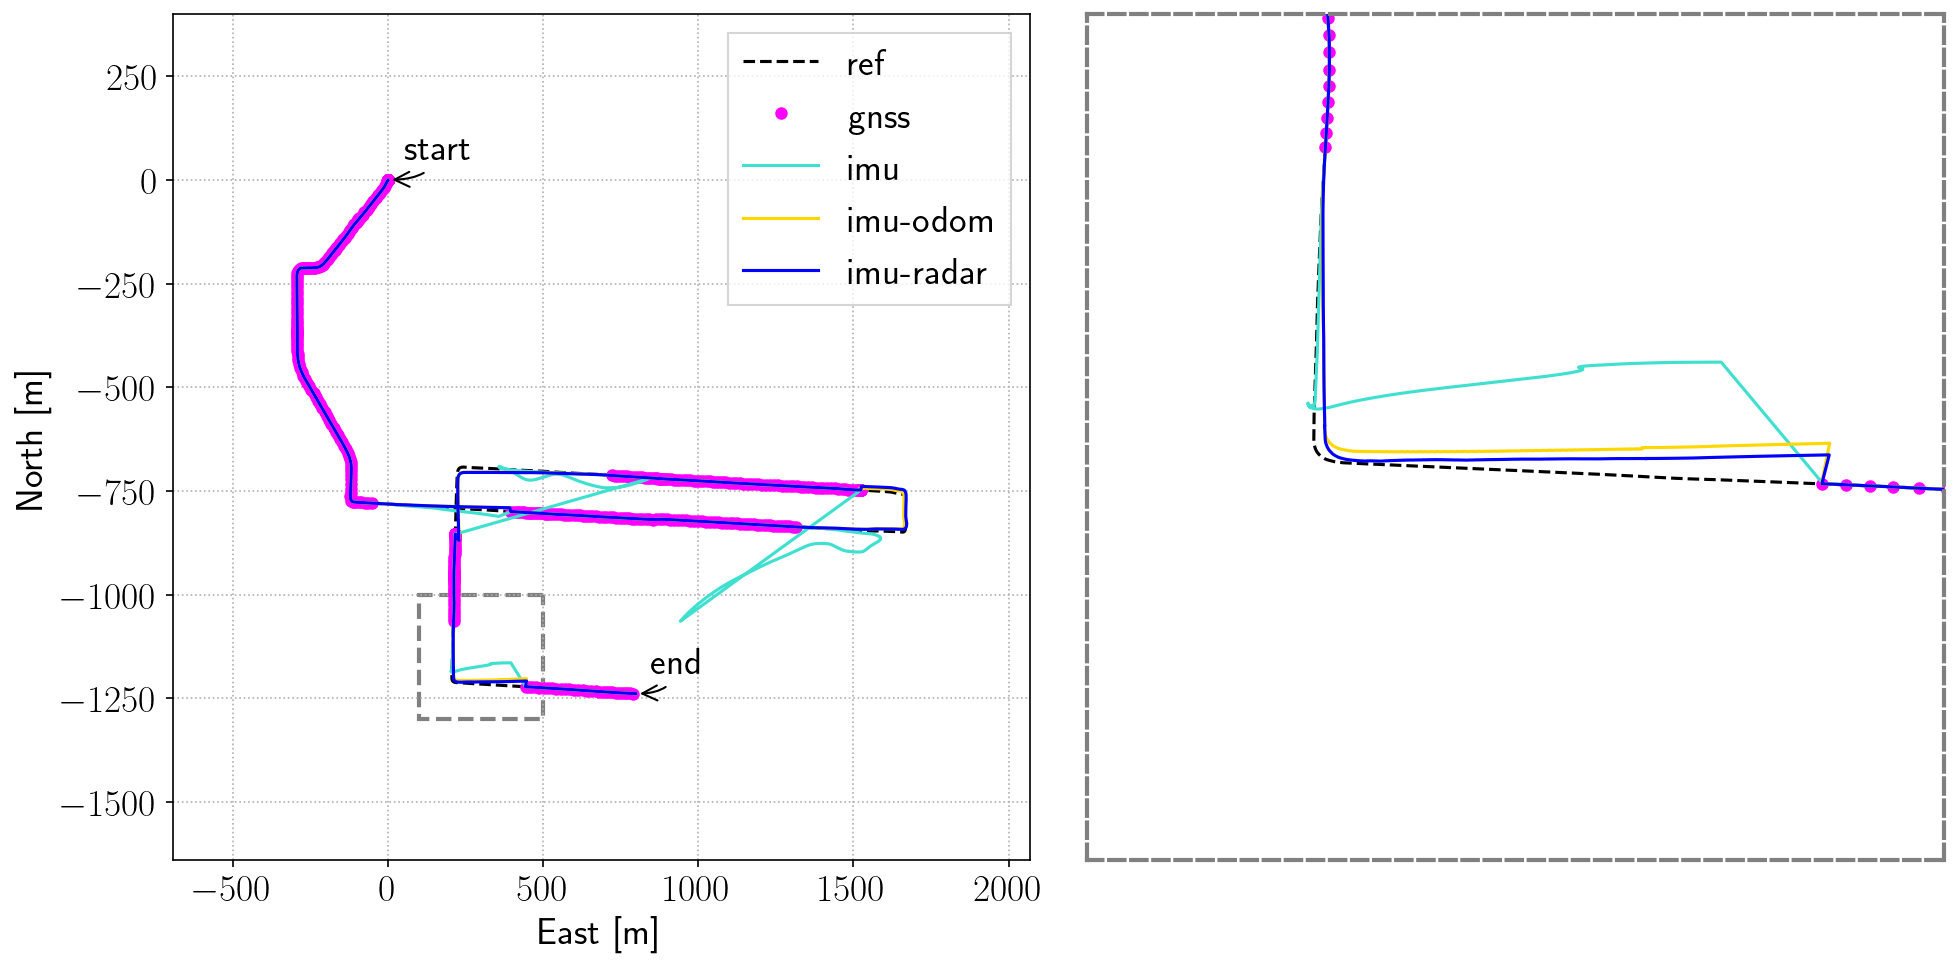

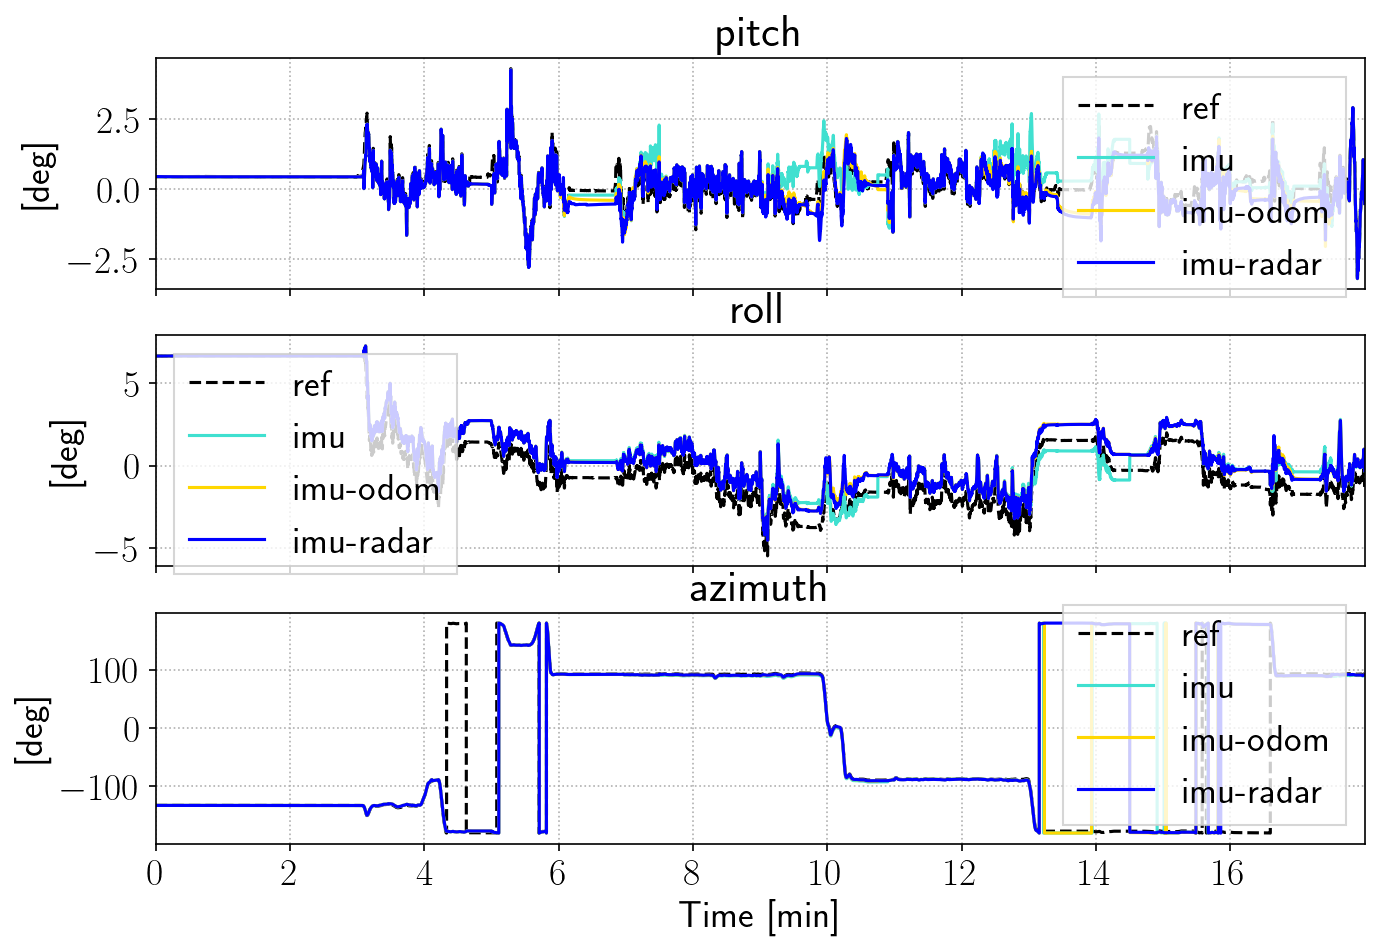

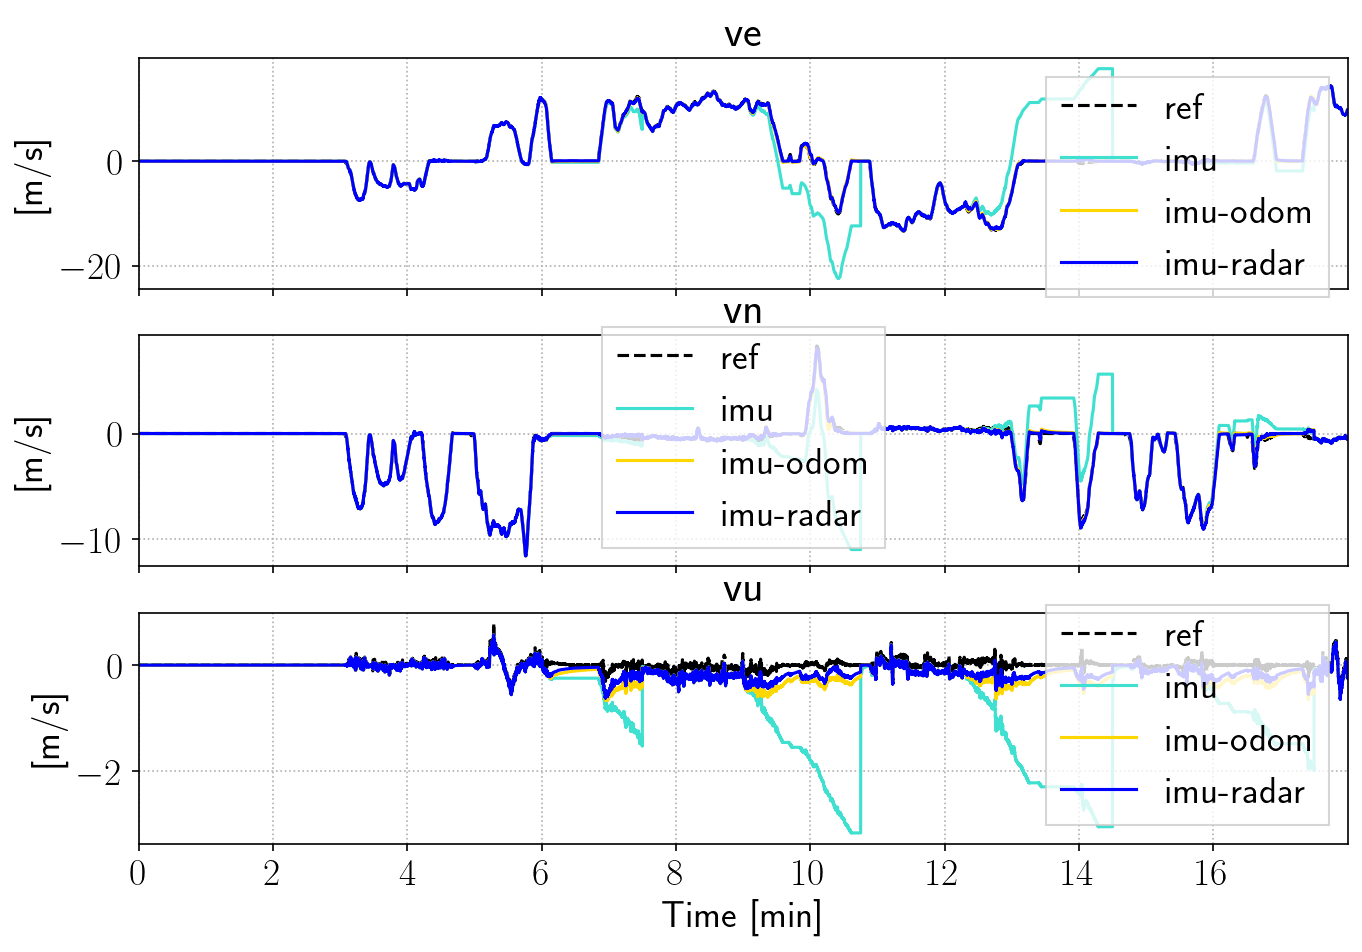


*** OUTAGES ***

OUTAGE 1 (Init: 5.983744458357493 | End: 7.500492485364278 | Interval: 91.005s | Distance: 448.63m)
imu
	 HERR RMSE (abs): 0.03m | VERR RMSE (abs): 0.015m
	 HERR RMSE (rel): 6.291m | % of Distance: 1.402
	 VERR RMSE (rel): 9.996m | % of Distance: 2.228

imu-odom
	 HERR RMSE (abs): 0.03m | VERR RMSE (abs): 0.015m
	 HERR RMSE (rel): 2.408m | % of Distance: 0.537
	 VERR RMSE (rel): 4.609m | % of Distance: 1.027

imu-radar
	 HERR RMSE (abs): 0.03m | VERR RMSE (abs): 0.015m
	 HERR RMSE (rel): 2.329m | % of Distance: 0.519
	 VERR RMSE (rel): 3.731m | % of Distance: 0.832

OUTAGE 2 (Init: 8.983915023008983 | End: 10.750675555070242 | Interval: 106.006s | Distance: 581.133m)
imu
	 HERR RMSE (abs): 1.12m | VERR RMSE (abs): 1.776m
	 HERR RMSE (rel): 216.492m | % of Distance: 37.253
	 VERR RMSE (rel): 49.745m | % of Distance: 8.56

imu-odom
	 HERR RMSE (abs): 0.464m | VERR RMSE (abs): 0.866m
	 HERR RMSE (rel): 5.988m | % of Distance: 1.03
	 VERR RMSE (rel): 1.653m | % of Distanc

In [61]:
for trajectory in [search_path + t + '/' for t in trajmulti.value]:
    
    # Headline
    tag = trajectory.split("/")[-2]
    print(f'===== TRAJECTORY: {tag} =====')
    
    # Reading data
    ref = pd.read_csv(trajectory + 'inspvax2.csv')
    imu = pd.read_csv(trajectory + 'zedFC-zed_front_center-imu-data_raw.csv')  # zedFC-zed_front_center-imu-data_raw
    rad = pd.read_csv('../processed/' + tag + '/front-left.csv')
    gps = pd.read_csv(trajectory + 'inspvax.csv')
    odo = pd.read_csv(trajectory + 'obd-speed.csv')
    
    # Adjusting headers
    ref.columns = ['Time'] + ["ref."+col for col in ref.columns if col != 'Time']
    imu.columns = ['Time'] + ["imu."+col for col in imu.columns if col != 'Time']
    rad.columns = ['Time'] + ["rad."+col for col in rad.columns if col != 'Time']
    gps.columns = ['Time'] + ["gps."+col for col in gps.columns if col != 'Time']
    odo.columns = ['Time'] + ["odo."+col for col in odo.columns if col != 'Time']
    
    # Merging data
    merged_df = imu.merge(ref, how='outer', on='Time')
    merged_df = merged_df.merge(rad, how='outer', on='Time')
    merged_df = merged_df.merge(gps, how='outer', on='Time')
    merged_df = merged_df.merge(odo, how='outer', on='Time')
    merged_df.fillna(np.inf, inplace=True)
    merged_df.sort_values(by=['Time'], inplace=True)
    merged_df.reset_index(inplace=True)
    
    # Time controller
    elapsed = 0
    
    # Auxiliary variables
    initialized = False
    stopped = False
    last_t = None
    last_gps_t = None
    last_imu_t = None
    outages  = []
    container = OrderedDict([('Time',[]),
                             ('gnss',[]),
                             ('ref',[]),
                             ('imu',[]),
                             ('imu-odom',[]),
                             ('imu-radar',[])
                            ])
    
    # Models
    Q = np.diag(np.square([1.6553283669466599e-03, 1.4321879095521371e-03, 1.4882234265217568e-03,
                            2.1797426064493874e-02, 1.9199991208121776e-02, 2.4879113136879506e-02,
                            0., 0., 0.,
                            5.2638535289061445e-06, 3.3703895968698511e-06, 4.6036018107732706e-06,
                            8.0578238813921381e-04, 2.9862524546587111e-04, 9.9432771946672657e-04
                          ]))
    
    P = np.square(np.eye(15)*1e-4)
    
    imu = LIEKF()
    imu.Q = Q
    imu.P = P
    
    imu_odom = LIEKF()
    imu_odom.Q = Q
    imu_odom.P = P
    
    imu_radar = LIEKF()
    imu_radar.Q = Q
    imu_radar.P = P
    
    # Time intervals to switch filters in seconds
    # intervals = [
    #              [merged_df.Time.iat[0]+5.95*60, merged_df.Time.iat[0]+7.25*60],
    #              [merged_df.Time.iat[0]+9*60, merged_df.Time.iat[0]+9.5*60],
    #              [merged_df.Time.iat[0]+13*60, merged_df.Time.iat[0]+14*60],
    #              [np.inf, np.inf] # ending condition
    #             ]
    
    intervals = [
             [merged_df.Time.iat[0]+6*60, merged_df.Time.iat[0]+7.5*60],
             [merged_df.Time.iat[0]+9*60, merged_df.Time.iat[0]+10.75*60],
             [merged_df.Time.iat[0]+12.25*60, merged_df.Time.iat[0]+14.5*60],
             [merged_df.Time.iat[0]+15.75*60, merged_df.Time.iat[0]+17.5*60],
             [np.inf, np.inf] # ending condition
            ]
    method = 'liekf'
    start, finish = intervals.pop(0)
    
    # Progress bar
    pbar = tqdm(total=merged_df.shape[0])
    
    
    # Looping group
    for i in range(merged_df.shape[0]):
        
        # Timestamp
        t = merged_df.Time.iat[i]
        
        # Managing early stop
        if stop_early:
            if elapsed >= total_time:
                break
                
        # Managing filters
        if start <= t <= finish and method=='liekf':
            temp = RIEKF()
            p, v, att, b_w, b_f = imu_odom.current()
            temp.initialize([*p, *v, *att, *b_w, *b_f])
            temp.Q = imu_odom.Q
            temp.P = imu_odom.Pl_to_Pr()
            imu_odom = copy.deepcopy(temp)
            
            temp = RIEKF()
            p, v, att, b_w, b_f = imu_radar.current()
            temp.initialize([*p, *v, *att, *b_w, *b_f])
            temp.Q = imu_radar.Q
            temp.P = imu_radar.Pl_to_Pr()
            imu_radar = copy.deepcopy(temp)
            
            method = 'riekf'
            
        elif t > finish and method=='riekf':
            temp = LIEKF()
            p, v, att, b_w, b_f = imu_odom.current()
            temp.initialize([*p, *v, *att, *b_w, *b_f])
            temp.Q = imu_odom.Q
            temp.P = imu_odom.Pr_to_Pl()
            imu_odom = copy.deepcopy(temp)
            
            temp = LIEKF()
            p, v, att, b_w, b_f = imu_radar.current()
            temp.initialize([*p, *v, *att, *b_w, *b_f])
            temp.Q = imu_radar.Q
            temp.P = imu_radar.Pr_to_Pl()
            imu_radar = copy.deepcopy(temp)
            
            method = 'liekf'
    
            if len(intervals) > 0:
                start, finish = intervals.pop(0)
                
        # Evaluating sensors
        if merged_df['gps.latitude'].iat[i] != np.inf:
            if initialized and method=='liekf':
                gps_lat = merged_df['gps.latitude'].iat[i]
                gps_lon = merged_df['gps.longitude'].iat[i]
                gps_hgt = merged_df['gps.height'].iat[i]
                gps_lat_std = merged_df['gps.latitude_stdev'].iat[i]
                gps_lon_std = merged_df['gps.longitude_stdev'].iat[i]
                gps_hgt_std = merged_df['gps.height_stdev'].iat[i]
                gps_ve = merged_df['gps.east_velocity'].iat[i]
                gps_vn = merged_df['gps.north_velocity'].iat[i]
                gps_vu = merged_df['gps.up_velocity'].iat[i]
                gps_ve_std = merged_df['gps.east_velocity_stdev'].iat[i]
                gps_vn_std = merged_df['gps.north_velocity_stdev'].iat[i]
                gps_vu_std = merged_df['gps.up_velocity_stdev'].iat[i]
                
                ned = lla2ned(gps_lat, gps_lon, gps_hgt, *origin[:3])
                enu = np.array([ned[1],ned[0],-ned[2]])
                
                y = [gps_ve, gps_vn, gps_vu, *enu]
                N = np.diag(np.square([gps_ve_std, gps_vn_std, gps_vu_std, gps_lon_std, gps_lat_std, gps_hgt_std]))
                # N = np.diag(np.square([1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]))
                imu.N = N
                imu_odom.N  = N
                imu_radar.N = N
                imu.correct(y=y)
                imu_odom.correct(y=y)
                imu_radar.correct(y=y)
                
                if not last_gps_t is None:
                    if (t - last_gps_t) > 5:
                        # Outage detected
                        outages.append([last_gps_t,t])

                container['gnss'].append(enu)
                last_gps_t = t
                
        
        elif merged_df['rad.speed'].iat[i] != np.inf:
            if initialized and method=='riekf':
                y = np.array([0., merged_df['rad.speed'].iat[i], 0.])
                imu_radar.N = np.diag(np.square([1e-1,1e-1,1e-1]))
                imu_radar.correct(y=y)
                
        
        elif merged_df['odo.speed'].iat[i] != np.inf:
            if initialized and method=='riekf':
                y = np.array([0., merged_df['odo.speed'].iat[i]/3.6, 0.])
                imu_odom.N = np.diag(np.square([1e-1,1e-1,1e-1]))
                imu_odom.correct(y=y)
        
            if merged_df['odo.speed'].iat[i] == 0:
                stopped = True
            else:
                stopped = False        
                
        
        elif merged_df['imu.linear_acceleration.x'].iat[i] != np.inf:                
            if initialized:
                meas = [-merged_df['imu.linear_acceleration.y'].iat[i], merged_df['imu.linear_acceleration.x'].iat[i], merged_df['imu.linear_acceleration.z'].iat[i],
                        -merged_df['imu.angular_velocity.y'].iat[i], merged_df['imu.angular_velocity.x'].iat[i], merged_df['imu.angular_velocity.z'].iat[i]]
                    
                dt = t - last_imu_t
                elapsed += dt
            
                # Predicting states
                if not stopped:
                    imu.predict(u=meas, dt=dt)
                    imu_odom.predict(u=meas, dt=dt)
                    imu_radar.predict(u=meas, dt=dt)
                    
            last_imu_t = t
        
        
        elif merged_df['ref.latitude'].iat[i] != np.inf:

            lat = merged_df['ref.latitude'].iat[i]
            lon = merged_df['ref.longitude'].iat[i]
            hgt = merged_df['ref.height'].iat[i]
            ve = merged_df['ref.east_velocity'].iat[i]
            vn = merged_df['ref.north_velocity'].iat[i]
            vu = merged_df['ref.up_velocity'].iat[i]
            pitch = merged_df['ref.pitch'].iat[i]
            roll  = merged_df['ref.roll'].iat[i]
            azi   = merged_df['ref.azimuth'].iat[i]
            
            if not initialized:
                origin = [lat, lon, hgt, ve, vn, vu, pitch, roll, azi]
                ned = lla2ned(lat, lon, hgt, *origin[:3])
                enu = np.array([ned[1],ned[0],-ned[2]])
                
                imu.initialize([*enu, ve, vn, vu, pitch, roll, azi, *np.zeros(6)])
                imu_odom.initialize([*enu, ve, vn, vu, pitch, roll, azi, *np.zeros(6)])
                imu_radar.initialize([*enu, ve, vn, vu, pitch, roll, azi, *np.zeros(6)])
                initialized = True
                
            # Storing data
            ned = lla2ned(lat, lon, hgt, *origin[:3])
            enu = np.array([ned[1],ned[0],-ned[2]])
            last_ref = [*enu, ve, vn, vu, pitch, roll, azi]
            container['Time'].append(t)
            container['ref'].append(last_ref)
            p_i, v_i, att_i, _, _ = imu.current()
            container['imu'].append([*p_i, *v_i, *att_i])
            p_i, v_i, att_i, _, _ = imu_odom.current()
            container['imu-odom'].append([*p_i, *v_i, *att_i])
            p_i, v_i, att_i, _, _ = imu_radar.current()
            container['imu-radar'].append([*p_i, *v_i, *att_i])
               
        
        last_t = t
        pbar.update(n=1)
        
    # Analysis for current trajectory
    analysis = Analysis(container)
    analysis.meta()
    analysis.export('../output/')
    # analysis.cdf()
    # analysis.errors()
    analysis.states()
    # analysis.boundaries([0.5,1.0,2.0,5.0,10.0,25.0,50.0])
    analysis.outages(outages)

In [10]:
# merged_df.columns.tolist()